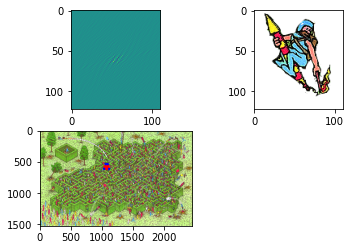

Offset_x_co =  1081.5 Offset_y_co =  575.5 value = 0.06097391842667277
Offset_x_co =  1020.0 Offset_y_co =  520.0 value = 0.06097391842667277
run time =  1.8616933822631836


NameError: name 'image_mean_2' is not defined

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import islice
import matplotlib.image as mpimg 


def convert_gray(image):
    #gray 1
    image = 0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 0] + 0.1140 * image[:, :, 0]
    
    return image

def read_image(image_name):
    """
    Read image 
 
    Inputs:
    ----------------
        image_name   Image path 
 
    Output:
    ----------------
        img  Image as multi channel array
       """      
    img = mpimg.imread(image_name)
    #im_array = np.array(img)

    return img


def matrix_fft(pattern):
    """
    FFT of the input array
 
    Inputs:
    ----------------
        pattern   2D array
        
    Output:
    ----------------
        fft2   FFT of array

     """
    #Take FFt along columns, then rows       
    fft1 = np.fft.fft(pattern, axis = 0)
    fft2 = np.fft.fft(fft1, axis = 1)

    return fft2

def matrix_ifft(pattern):
    """
    IFFT of the input array
 
    Inputs:
    ----------------
        pattern   2D array
        
    Output:
    ----------------
        ifft2   FFT of array

     """  

    #Take IFFt along columns, then rows    
    ifft1 = np.fft.ifft(pattern, axis = 0)
    ifft2 = np.fft.ifft(ifft1, axis = 1)

    return ifft2


def matrix_complex_conj(pattern):
    """
    Complex of the input array
 
    Inputs:
    ----------------
        pattern   2D array
        
    Output:
    ----------------
        pattern_fft_conj   Complex conjugate of array

     """  

    pattern_fft_conj = np.conj(pattern)

    return pattern_fft_conj 


def zero_padding(C, x_pad, y_pad):
    """
    Zero pad 2D array by placing it in centre of zeroed matrix of padded size.
 
    Inputs:
    ----------------
        array   The array to pad
 
        padlen_x    Padwidth of the rows. Floats will be rounded up.
        
        padlen_y    Padwidth of the columns. Floats will be rounded up.
 
    Output:
    ----------------
        padded  Padded template array.  
     """        

    m,n = C.shape
    
    #needs to be int to work not float make this into a round up if float function or find libray function 
    if x_pad% 2 == 0:
        x_pad = int(x_pad)
    else: 
        x_pad = int( x_pad + 0.5 )

    if y_pad% 2 == 0:
        y_pad = int(y_pad)
    else: 
        y_pad = int( y_pad + 0.5 )
           
    c_y = np.zeros((m +2*x_pad , n+2*y_pad ),dtype=C.dtype)
    c_y[x_pad:-x_pad:, y_pad:-y_pad] = C
    return c_y
    
    
    # x_pad = int(np.round(x_pad))
    # y_pad = int(np.round(y_pad))
    
    # return np.pad(C, [(x_pad, ), (y_pad, )], mode='constant')


def nextpow2(n):

    """get the next power of 2 that's greater than n"""
    m_f = np.log2(n)
    m_i = np.ceil(m_f)

    return 2**m_i


def crr_2d( pattern, template):
    """
    Cross correlation of two 2D arrays using FFt to convolve spatial arrays
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty 

        template   Template, search space with similar dimensionality to pattern
        
    Output:
    ----------------
        real_corr  Cross correlation array
     """  

    min_height_pad = max(pattern.shape[0], template.shape[0])
    min_width_pad = max(pattern.shape[1], template.shape[1]) 
    # find closes power of 2 for height and width (np.fft runs faster) 
    optimal_width = nextpow2(min_width_pad) 
    optimal_height = nextpow2(min_height_pad) 

    height_pad_p = optimal_height - pattern.shape[0]
    width_pad_p = optimal_width - pattern.shape[1]
    height_pad_t = optimal_height - template.shape[0] 
    width_pad_t = optimal_width - template.shape[1] 

    # pad pattern as centre of array with zeros
    pattern_padded = zero_padding( pattern, height_pad_p /2, width_pad_p /2 ) 
    template_padded = zero_padding( template, height_pad_t /2, width_pad_t /2  )

    #testing
#     print("image shape = ", pattern.shape)
#     print("template shape = ", template.shape)
#     print("\nmin and optimal sizes ")
#     print(min_height_pad, min_width_pad) 
#     print(optimal_height, optimal_width)
#     print("difference for template padding extra height = ", height_pad_t)
#     print("difference for template padding extra width = ", width_pad_t)
#     print("padded shapes")
#     print("pattern_padded shape = ", pattern_padded.shape)
#     print("template_padded shape = ", template_padded.shape)

    template_fft = matrix_fft(template_padded) #(a)
    pattern_fft_conj = matrix_complex_conj( matrix_fft(pattern_padded) ) # (b)

    # a * b
    #Offset pattern due to padding
    #product = pattern_fft_conj[0: pattern_fft_conj.shape [0], 0: pattern_fft_conj.shape [1]] *  template_padded      
    product = pattern_fft_conj *  template_padded      
    ccr = matrix_ifft(product)
    
    real_corr = np.real(ccr) #np.real

    return real_corr, height_pad_t, width_pad_t


#function that finds the largest element and its index in an array
def find_best_match(score):
    """
    Find max value in 2D array and its index
 
    Inputs:
    ----------------
        score   2D target array
        
    Output:
    ----------------
        index   Index of largest element 
        
        max_element Max Element in the array

     """      
    #try:
    max_element = np.amax(score)
    #except:
    #    print( "Line 45 Error", score )
    index = np.unravel_index(np.argmax( score, axis=None), score.shape) 
    #index = np.argmax(score)

    return index, max_element # tuple = list, int


def find_offset(pattern, template): 
    """
    2D array offset index and value from cross correlation 
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty 

        template   Template, search space with similar dimensionality to pattern
        
    Output:
    ----------------
        (best_score, best_match)  Index of offset found from cross correlation
     """     
    
    '''
    new resizing for odd sides
    '''
    extra_row = 0
    extra_col = 0
    a = pattern
    b = template
    if a.shape[0]%2!=0:
    #     w = a.shape[1]
    #     h = a.shape[0]
    #     #a= np.ones( (h+1,w))
    #     a1 = np.zeros((h+1,w))
    #     #a[:-1,:] = pattern_gray
        extra_row = 1
        a = np.vstack((a,np.zeros( (1,a.shape[1])  )))

    if a.shape[1]%2!=0:
    #     w = a.shape[1]
    #     h = a.shape[0]
    #     #a= np.ones( (h,w+1))
    #     a1 = np.zeros((h,w+1))
        extra_col = 1
        a = np.hstack((a,np.zeros( (a.shape[0],1) )))

    if b.shape[0]%2!=0:
    #     w = b.shape[1]
    #     h = b.shape[0]
    #     #b= np.ones( (h+1,w))
    #     b1 = np.zeros((h+1,w))
        b = np.vstack((b,np.zeros( (1,b.shape[1]) )))
        
    if b.shape[1]%2!=0:
    #     w = b.shape[1]
    #     h = b.shape[0]
    #     #b= np.ones( (h,w+1))
    #     b1 = np.zeros((h,w+1))
        b = np.hstack((b,np.zeros( (b.shape[0],1) )))

    pattern = a
    template = b
    
    #new padding
    real_corr, off_x, off_y = crr_2d( pattern, template)
    # real_corr = crr_2d( pattern, template) old padding

    best_match , match_value = find_best_match( real_corr )
    #print( best_match )

    # return (best_match[0] - 2 * pattern.shape[0], best_match[1] - 2 * pattern.shape[1]), match_value
    return (best_match[0] - off_x/2 - extra_row - 2*pattern.shape[0], best_match[1] - off_y/2 - extra_col - 2*pattern.shape[1]), match_value #last working

#     #newest 
#     mid_vert_co = best_match[0] - off_x/2 - 2*pattern.shape[0]
#     mid_horiz_co = best_match[1] - off_y/2 - 2*pattern.shape[1]
#     # mid_vert_co_2 = best_match[0] - pattern.shape[0]
#     # mid_horiz_co_2 = best_match[1] - pattern.shape[1]
#     # print("mid_vert = ", mid_vert_co)
#     # print("mid_horz = ", mid_horiz_co)
#     # print("mid_vert = ", mid_vert_co_2)
#     # print("mid_horz = ", mid_horiz_co_2)
    
#     return ( mid_vert_co, mid_horiz_co ), match_value



def main():

    patternDir = "wallypuzzle_rocket_man.png"
    templateDir = "wallypuzzle_png.png"

    pattern = np.array(read_image( patternDir ) )
    template = np.array(read_image( templateDir ) )
    
    #gray 1
    pattern_gray = convert_gray( pattern )
    template_gray = convert_gray( template )
    
    pattern_s = pattern_gray - np.mean(pattern_gray)
    template_s = template_gray - np.mean(template_gray)
        
    start = time.time()
    image_cross, image_cross_value = find_offset( pattern_s, template_s)
    end = time.time()

    #function to find aimage centre
    vertCen = pattern.shape[1]/2
    horCen = pattern.shape[0]/2

    #plot shift FFT of image
    plt.subplot(2,2,1)
    plt.imshow( np.fft.fftshift( np.imag(matrix_fft(pattern_s)) ) ) 
    plt.subplot(2,2,2)
    plt.imshow( mpimg.imread( patternDir ) )   
    plt.subplot(2,2,3)
    plt.imshow( mpimg.imread( templateDir ) )  
    circle=plt.Circle(( image_cross[1] + vertCen ,\
    image_cross[0] + horCen  ),\
    50,facecolor='red', edgecolor='blue',linestyle='dotted', \
    linewidth='2.2')
    plt.gca().add_patch(circle)  
    plt.show()    
    plt.ion()    

    print("Offset_x_co = ", image_cross[1] + horCen , "Offset_y_co = ", image_cross[0] + vertCen, "value =", image_cross_value)
    print("Offset_x_co = ", image_cross[1] , "Offset_y_co = ", image_cross[0] , "value =", image_cross_value)
    print("run time = ", end - start )
    plt.ion()
    
#     pattern_image = read_image( patternDir )
#     template_image = read_image( templateDir ) 
    
#     test_plot = image_mean_2[ (image_cross[1] - image_mean_1.shape[0]) : (image_cross[1]+image_mean_1.shape[0]),\
#                              (image_cross[0]-image_mean_1.shape[1]): (image_cross[0]+image_mean_1.shape[1]) ]
#     plt.imshow( test_plot )
    

#     print("Offset_x_co = ", image_cross[0]+( image_mean_1.shape[0] / 2), "Offset_y_co = ", \
#           image_cross[1]+( image_mean_1.shape[1] / 2) )

#     test_plot = template_image[ image_cross[0] : image_cross[0] + pattern_image.shape[0],  image_cross[1] : image_cross[1] + pattern_image.shape[1], : ] 
#     plt.imshow( test_plot )




if __name__ == '__main__':
    
    main()

"""
Offset_x =  528 Offset_y =  982 value = 0.520092887633342
<class 'numpy.ndarray'>
"""